# Interpretability: Towards Explainable Machine Learning
#### Yassin Bahid

## Introduction:

Deep Learning Methods have gained in popularity recently in both commercial and industrial uses and Scientific areas. While the focus has always been on the accuracy, there is an increasing demand for an explanation of the way models function and arrives at decisions. In scientific fields, explainability is a prerequisite. Yet, there has been a lack of explainability and interpretability of the model. We shall first define what we mean by interpretability, before looking at different methods that try to achieve it. We will focus solely on Image classification Deep networks such as VGG and Resnet.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import time
from PIL import Image
import os.path

## Basic Concepts:

### Transparency:

A machine learning method is called transparent if the process can be described and motivated by the approach designer. One can differentiate between different types: model, design, and algorithmic transparency. DNN seems to be not fully transparent. They do achieve Algorithmic and model transparency, given that one can mathematically express the algorithm used using gradient stochastic descent, and justify mathematically the validity of such theory. However, the motivation behind the design or architecture, of each DNN is not fully transparent.

### Interpretability:

We consider interpretability as making sense of the obtained ML model. Generally, to interpret means “to explain the meaning of” or “present in understandable terms”. We shall distinguish this concept from Explainability which is defined below. Thus, interpretability can be seen as the mapping of an abstract concept (e.g., a predicted class) into a domain that humans can make sense of. While this idea is rather abstract, we shall try to quantify this concept and develop processes to achieve this mapping.

### Explainability:

Explainability is a surprisingly difficult concept to pin down. As explained in Roscher's paper, there is a gap between the expectations of an explanation between DNN and other "explanation" sciences such as law, physics, etc. Explainability can be measured as the ability of the designer to answer three classes of questions: 
 - What did the model do?
- How did the model do it?
- Why did the model do it?

As such, Explanbility can be defined as the collection of features of the interpretable domain, that have
contributed for a given example to produce a decision.

# Concrete Exploration:

We now focus specifically on the image classification DNN's. We use Torchvision pre-trained models on ImageNet. These Networks vary widely in accuracy, depth, and structure. However, they are all considered to be successful architectures of an image classifier Neural Network. Thus, comparing their different features will perhaps give us insight into their interpretability explainability, and Transparency.

In [8]:
Models = {'vgg11': models.vgg11(pretrained = True),
          'vgg11_bn': models.vgg11_bn(pretrained = True),
          'vgg13': models.vgg13(pretrained = True),
          'vgg13_bn': models.vgg13_bn(pretrained = True),
          'vgg16': models.vgg16(pretrained = True),
          'vgg16_bn': models.vgg16_bn(pretrained = True),
          'vgg19': models.vgg19(pretrained = True),
          'vgg19_bn': models.vgg19_bn(pretrained = True),
          'resnet18': models.resnet18(pretrained = True),
          'resnet34': models.resnet34(pretrained = True),
          'resnet50': models.resnet50(pretrained = True),
          'resnet101': models.resnet101(pretrained = True)
         }

## Weight Exploration:

The most basic parameter we have access to is the weights of each layer. We can look at different statistics such as histograms or distributions. We choose to start with the sum of all weights per layer per Neural Net architecture. The figure below presents a bar plot of the sum of each and every layer's weights. 

This graph does not offer much in terms of interpretability or explainability. However, It does help with transparency. It seems that high-performing models all have exponential growth in terms of the weights used. Thus, the success of these architectures can be used in informing the design of future Neural Nets. Making the number of nodes grow with the depth of the model, and thus grow the number of weights, seems to lead to more performant models. Of course, this conclusion can seem a bit naive. It might change given different summary statics. However, it offers the first step toward design transparency. 

In [7]:
def weight_sum(model):
    lyr_weights = []
    lyr_bias = []
    for layer in list(model.children()):
            for ky in layer.state_dict().keys():
                if 'bias' in ky:
                    lyr_bias += [layer.state_dict()[ky].sum().item()]
                else:
                    lyr_weights += [layer.state_dict()[ky].sum().item()]
    return lyr_weights, lyr_bias

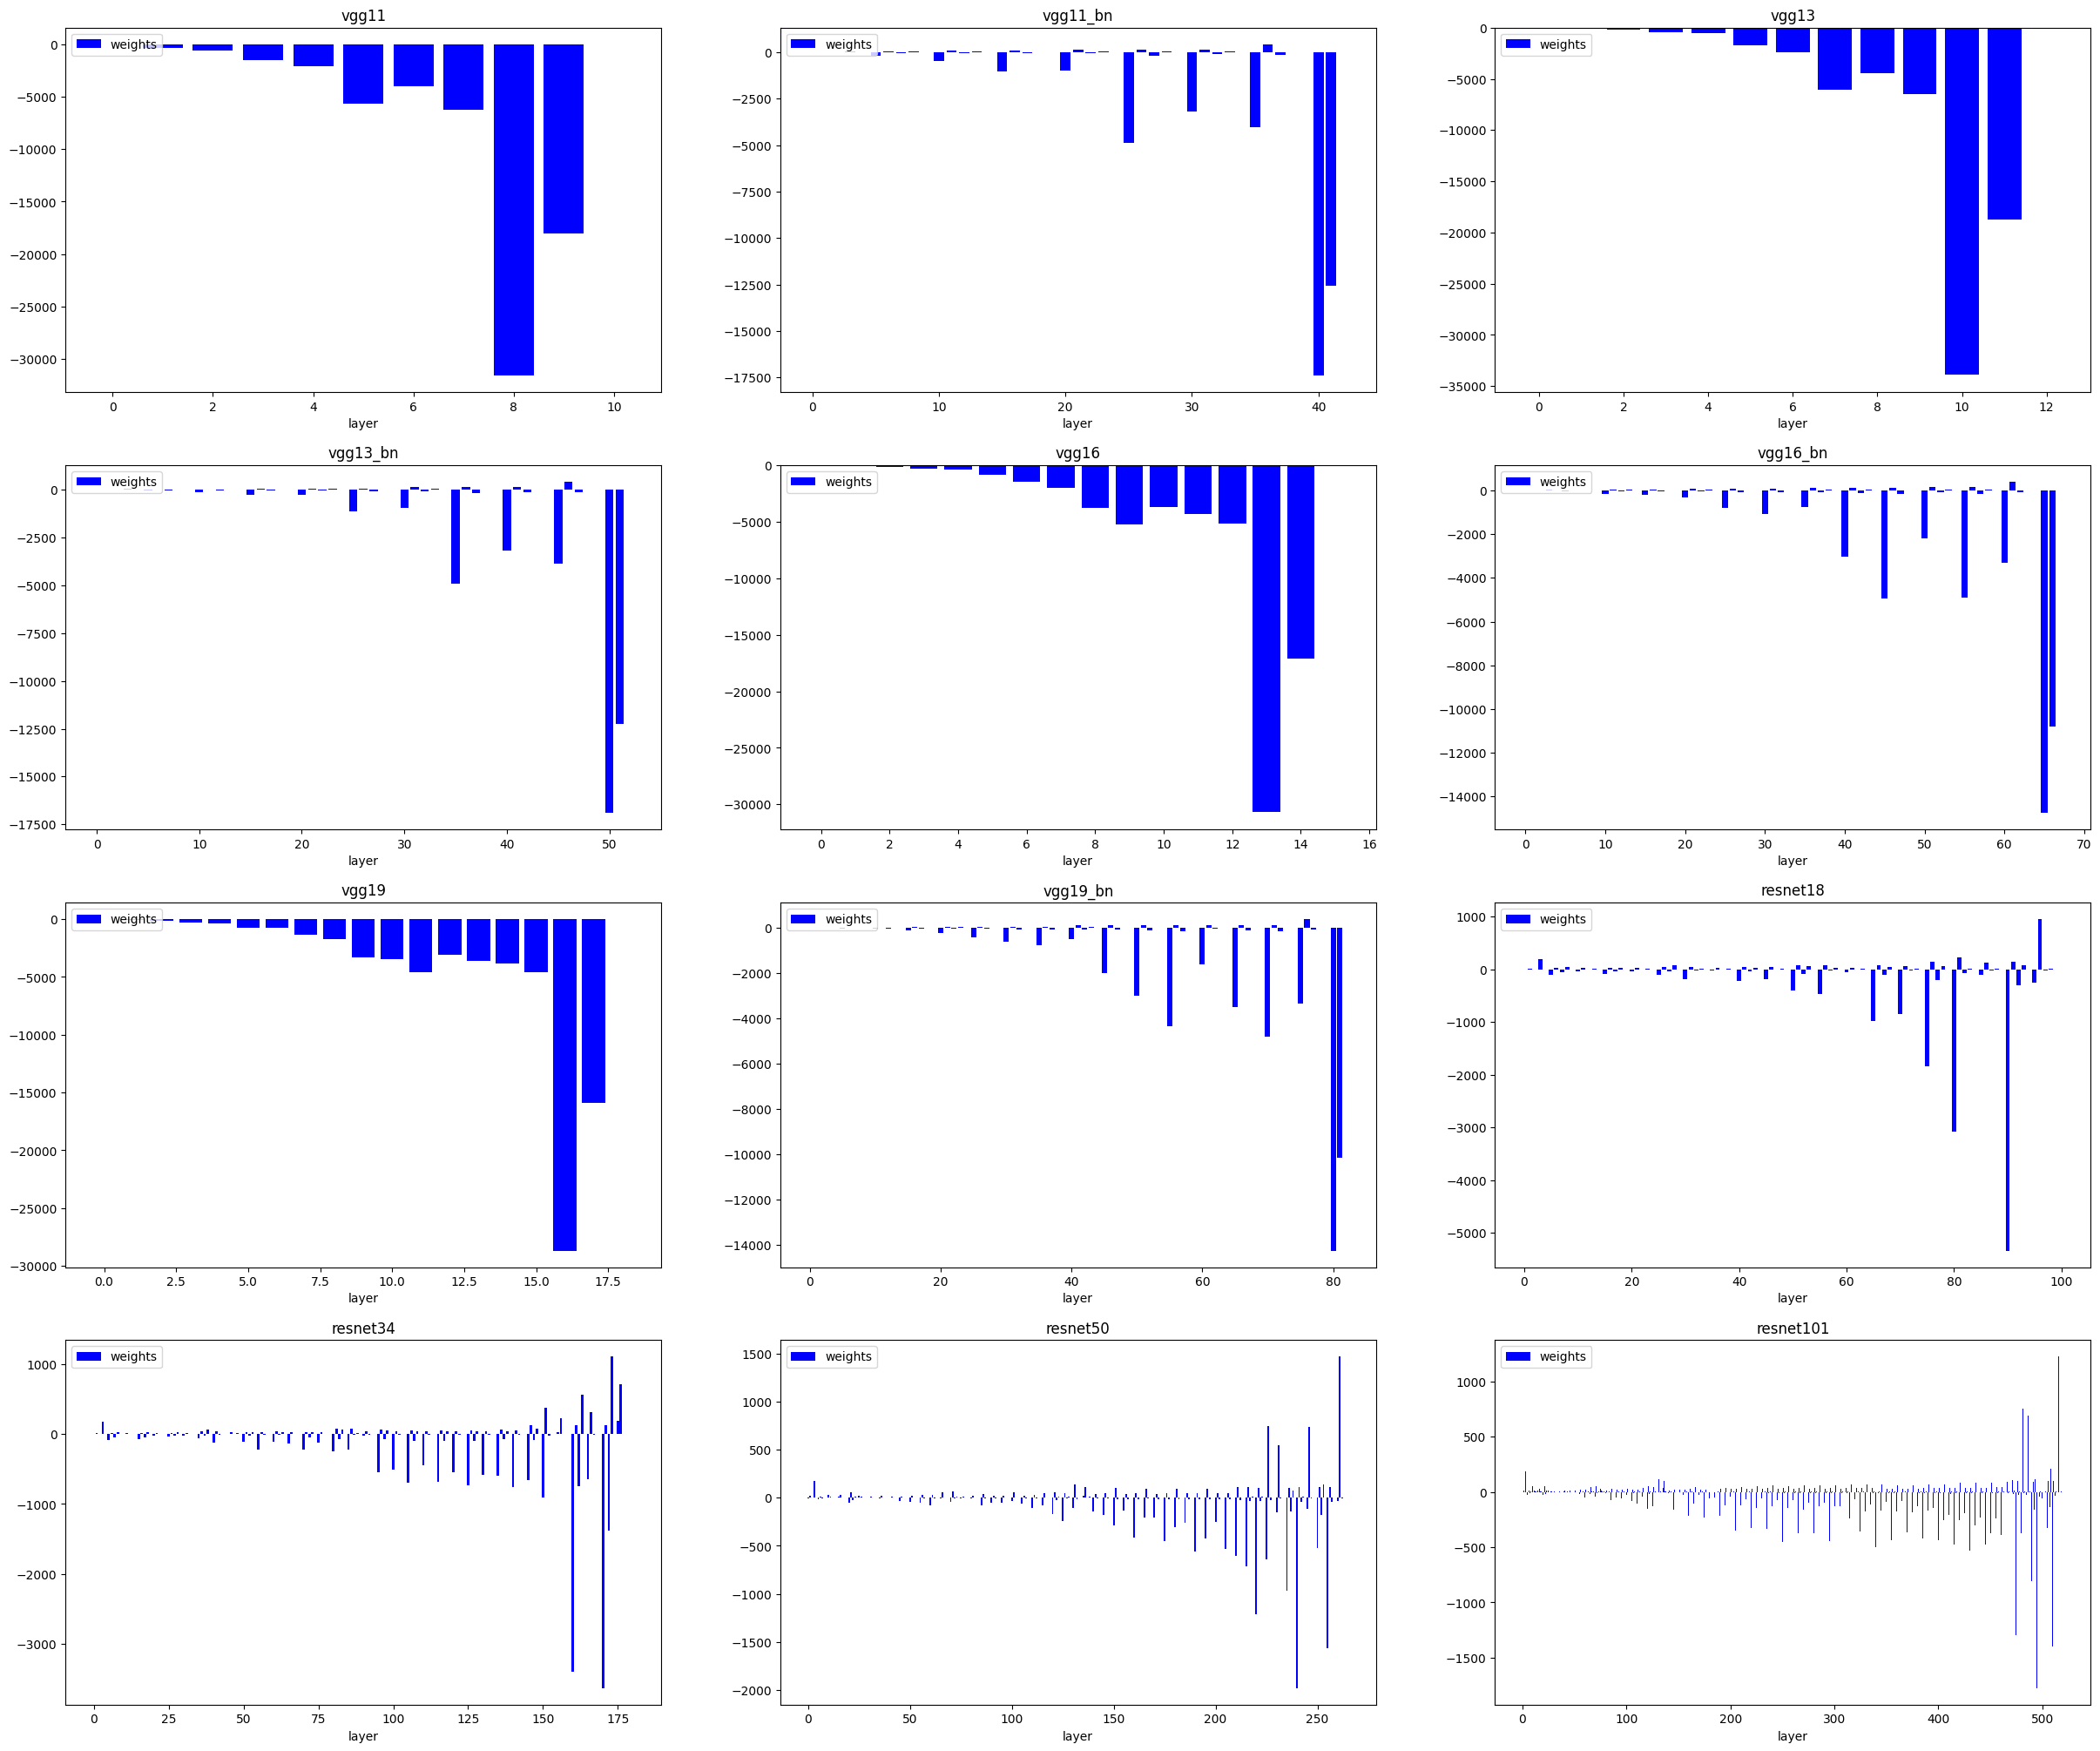

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(30,25))

ax_lst = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2], [3,0], [3,1], [3,2]]
i = 0
for ky in Models.keys():
    lyr_weights, lyr_bias = weight_sum(Models[ky])
    lyr = [j for j in range(0, len(lyr_weights))]
    leg = ['weights', 'bias']
    ax[ax_lst[i][0], ax_lst[i][1]].bar(lyr, lyr_weights, color = 'blue', align = 'center')
    ax[ax_lst[i][0], ax_lst[i][1]].set_xlabel('layer')
    ax[ax_lst[i][0], ax_lst[i][1]].set_title(ky)
    ax[ax_lst[i][0], ax_lst[i][1]].legend(leg,loc=2)
    i +=1

## Feature Maps:

In our quest for transparency, we can look at feature maps. The output of every convolutional layer might offer insight as to what the model is doing exactly:
-What shapes is it targeting?
-what features are most important for the Classification?
In order to keep this report concise, we choose to only focus on 3 DNN Architectures: VGG19, VGG19_bn, and Resnet18.
We use an image pulled out of the ImageNet database, which we transform in order to get through the model.

Text(0.5, 1.0, 'A very good boy')

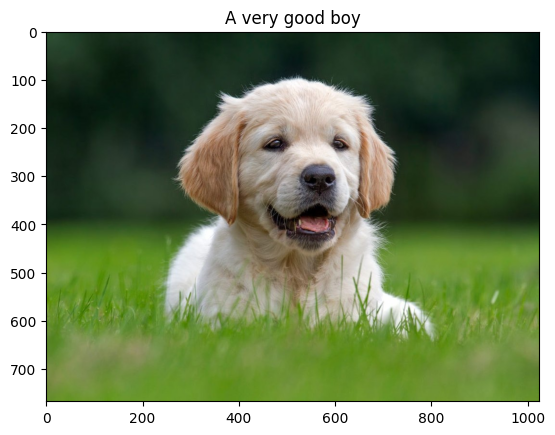

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

dog_img = Image.open('dog.jpg')
plt.imshow(dog_img)
plt.title('A very good boy')

In [11]:
def conv_layer_weights(model):
    # we will save the conv layer weights in this list
    model_weights =[]
    #we will save the 49 conv layers in this list
    conv_layers = []
    # get all the model children as list
    model_children = list(model.children())
    # print(model_children)
    #counter to keep count of the conv layers
    counter = 0
    #append all the conv layers and their respective wights to the list
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
           
            for j in range(len(model_children[i])):
                
                if type(model_children[i][j]) == nn.Conv2d:
                    counter+=1
                    model_weights.append(model_children[i][j].weight)
                    conv_layers.append(model_children[i][j])
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        counter+=1
                        model_weights.append(child.weight)
                        conv_layers.append(child)
#     print(f"Total convolution layers: {counter}")
#     print("conv_layers")
    return conv_layers
    

In [12]:
def FeatMap(conv_layers, Image):
    
    image = transform(Image)
    # print(f"Image shape before: {image.shape}")
    image = image.unsqueeze(0)
    print(f"Image shape after: {image.shape}")
    # image = image.to(device)
    
    outputs = []
    names = []
    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))
    
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title('layer ' + str(i), fontsize=10)


### VGG19:
We present the feature maps in the figure below.
While certain layers do focus on the entire image, quite a few try to detect certain shapes. Layer 0 focuses on round shapes such as the eyes or the nose. But it also is concerned with the background. Layers 6, 10, 12, and 14 are more concerned with edge detection. Layer 5 focuses on the dog itself while also focusing on the grass. We can thus interpret the importance of each layer.

Image shape after: torch.Size([1, 3, 224, 224])
16


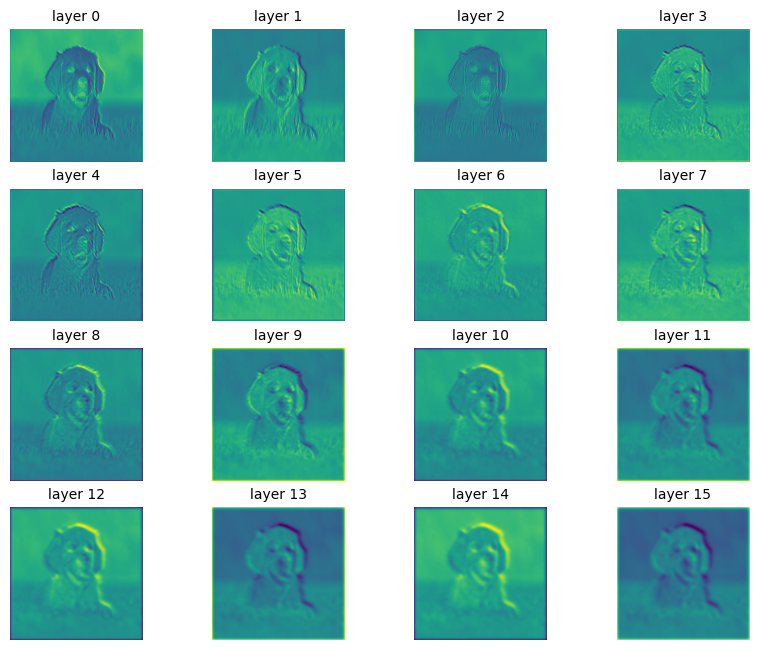

In [13]:
vgg19 = models.vgg19(pretrained = True)
dog_img = Image.open('dog.jpg')
FeatMap(conv_layer_weights(vgg19), dog_img)

### VGG19 w/ Batch Normalization:
While adding batch normalization seems like a rather benign process, it is impressive to see how different the feature maps presented below are. Layers 0 and 4 successfully isolate grass from the dog while layer 5 does the opposite. Layers 3, 10, 11, and 14 all find different edges that form the image of the dog. Other layers dow take into account the shape of the ears, mouth, and nose.

Image shape after: torch.Size([1, 3, 224, 224])
16


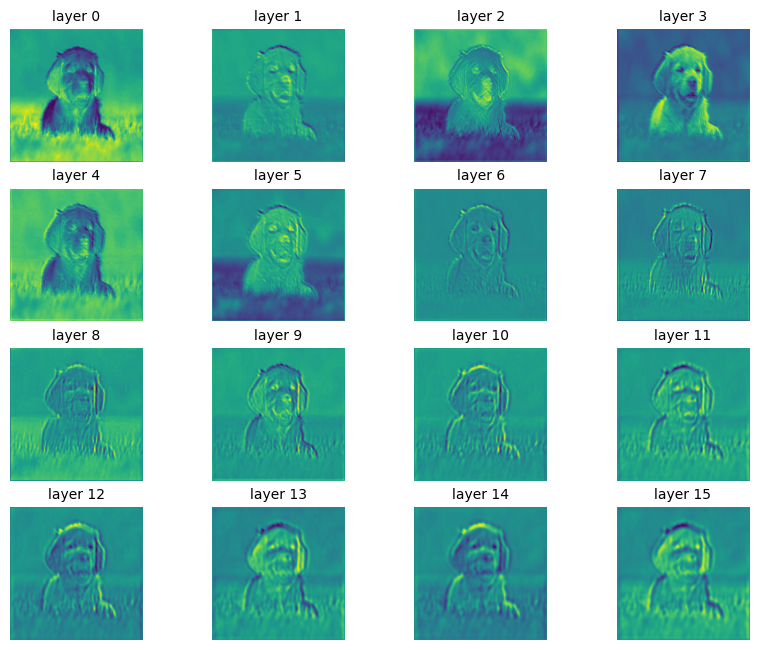

In [14]:
vgg19_bn = models.vgg19_bn(pretrained = True)
dog_img = Image.open('dog.jpg')
FeatMap(conv_layer_weights(vgg19_bn), dog_img)

### Resnet18:

While this model is the most accurate of the 3, not all feature maps are interpretable to the human eye. However, one can see from the figure below that the model focus o different shapes at first, then moves to edges. The last couple of feature maps is of course hard to read or interpret. 


#### Note on rigor:
Of course, these interpretations are just made by one person and do not have rigorous scientific backing. Looking at the topology of each feature map and using geometric and topological arguments can help quantify these interpretations and perhaps help define an interpretability score for each model. 

Image shape after: torch.Size([1, 3, 224, 224])
17


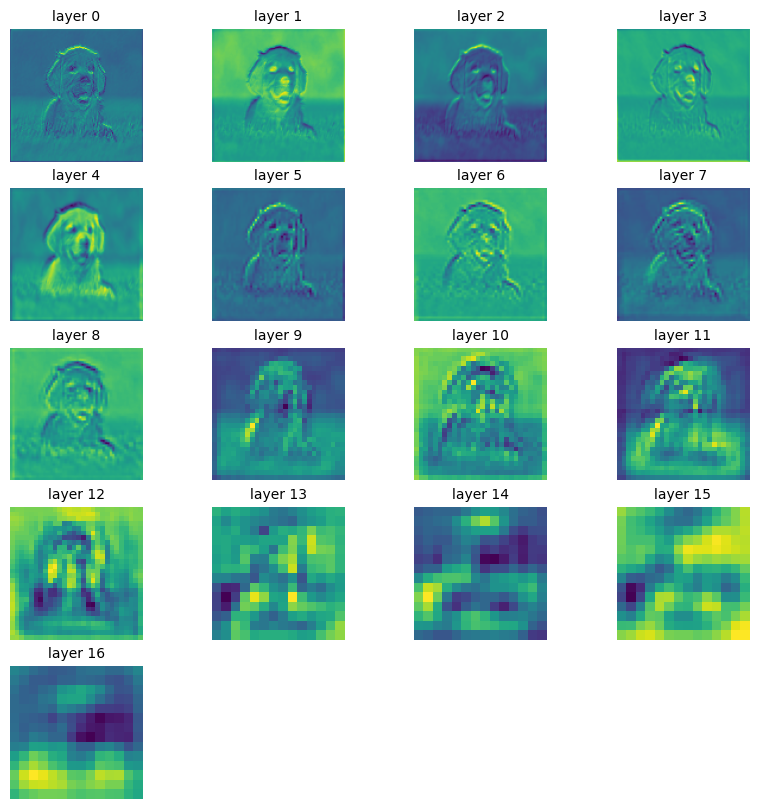

In [15]:
resnet18 = models.resnet18(pretrained = True)
dog_img = Image.open('dog.jpg')
FeatMap(conv_layer_weights(resnet18), dog_img)

## Saliency Map:

A saliency map is a heat map that highlights the most important pixels in specific in a specific classification.
For a specific class $c$, and image $ I$, the score of the class is:


$$
S(I) = w_c^TI + b_c
$$


where $w_c$ and $b_c$ are the weights and biases of the class. 
the gradient is what decides the importance of the weights. Additionally:


$$
w_c = \frac{d S(I)}{d I}
$$


Once we compute this weight via backward propagation, we can use it to draw a heat map for each pixel.

In [20]:
def preprocess(image, size=224):
    transform = transforms .Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = T.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [26]:
def SalMap_generator(model, img):
    for param in model.parameters():
        param.requires_grad = False
    # preprocess the image
    X = preprocess(img)

    # we would run the model in evaluation mode
    model.eval()

    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()

    '''
    forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
    and we also don't need softmax, we need scores, so that's perfect for us.
    '''

    scores = model(X)

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    '''
    backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
    score_max with respect to nodes in the computation graph
    '''
    score_max.backward()

    '''
    Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
    R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
    across all colour channels.
    '''
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)

    # code to plot the saliency map as a heatmap
    plt.imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    # plt.title('model')
    plt.show()

### VGG19:

VGG19 mainly focuses on the center of the image. Especially the shape of the dog while ignoring the background and grass.

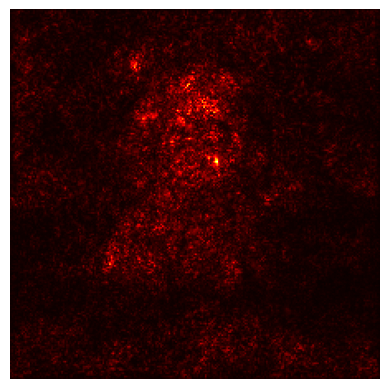

In [19]:
SalMap_generator( models.vgg19(pretrained=True), Image.open('dog.jpg'))

### VGG19 w/ Batch Normalization:


VGG19 with Batch normalization focuses on much more pixels. While the focus is still on the center of the image, recognizing the background is important too.

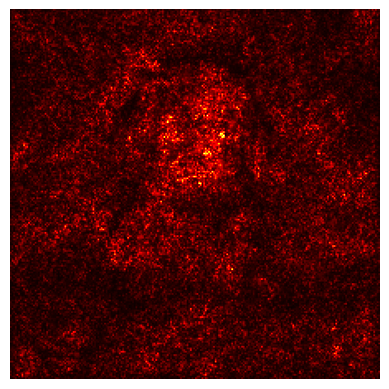

In [20]:
SalMap_generator( models.vgg19_bn(pretrained=True), Image.open('dog.jpg'))

### Resnet18:

Resnet18 focuses on the top of the image. It ignores the grass at the bottom of the image but does value the sky as relevant to classification. One possible interpretation is that distinguishing the contours of the dog versus the background is important. It might also be that most images present the important features of the dog in the top half of the image.

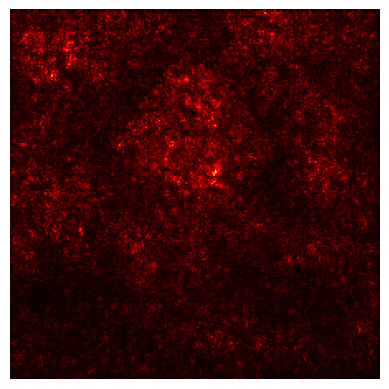

In [21]:
SalMap_generator( models.resnet18(pretrained=True), Image.open('dog.jpg'))

## Network Topology:


On last possible way to study DNNs is to look at their topology and structure from a network analysis perspective. DNNs can be seen as directed, weighted graphs, where the perceptrons are seen as vertices, and the weights of a layer consist of the edges that connect it to the previous layer. This approach is relatively new and still in development. Unfortunately;y, no significant research was found in the models we are looking at. A visualization tool is being developed for basic dummy models. Once it is complete, it could offer great insight into the relevancy of certain connections and how to interpret them.

https://github.com/tonio73/dnnviewer

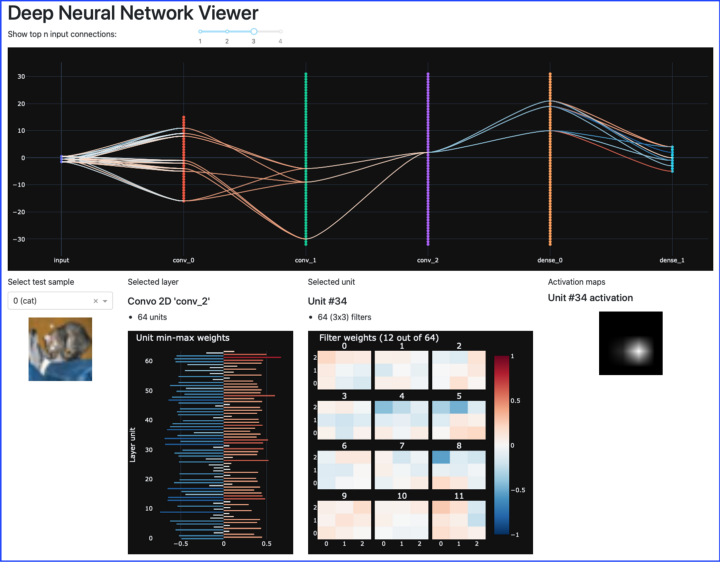

# Conclusion:
 
We have offered some concrete technics to evaluate the transparency, interpretability, and explainability of Classification Deep Neural Networks. There is much development that can benefit the field such as a more mathematically rigorous approach to interpretability. A more robust grasp of these concepts can eventually inform design choices in the future. Different problems might require different approaches. Audiovisual classification or NLP programs cannot be as easily Interpreted. However, These methods are a good first step toward interpretable Deep Learning.